# BERT Multilabel Classification for Toxic Comments

## Import

In [1]:
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import os
import re
import sys
import string
import sklearn
import numpy as np
import pandas as pd

## Caricamento dei dati
Il dataset di partenza è stato preso da una [challenge](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/) pubblicata su [Kaggle](https://www.kaggle.com/) nel 2018 da [Jigsaw](https://jigsaw.google.com/)

In [3]:
# Load the data
train_data = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [4]:
# Test data + labels
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
test_labels = pd.read_csv('data/test_labels.csv')
test_df = test_df.merge(test_labels, on='id', how='right')
test_data = test_df[~test_df['toxic'] == -1]

## Data analysis (pt.1) e subsampling
Il dataset risulta essere molto sbilanciato, per questo motivo è stato optato per un subsampling della classe dominante, che risulta essere quella con tutte le classi poste a zero.  
Si è scelto di utilizzare la proporzione 50/50, dove metà del dataset risultano essere commenti "puliti", mentre l'altra metà dei record ha un qualche grado di tossicità.

In [5]:
def good_ppl_counter(data):
    count = 0
    for d in range(len(data)):
        if data['toxic'][d] == 0 and data['severe_toxic'][d] == 0 and data['obscene'][d] == 0 and data['threat'][d] == 0 and data['insult'][d] == 0 and data['identity_hate'][d] == 0:
            count += 1
    return count

def bad_ppl_counter(data):
    count = 0
    for d in range(len(data)):
        for s in labels:
            if data[s][d] == 1:
                count += 1
                break
    return count

# Length of the train data
print(f'Lenght of train data: {len(train_data)}')
print(f'Good people: {good_ppl_counter(train_data)}')
print(f'Bad people: {bad_ppl_counter(train_data)}')
print('..........')

# Record count for each label
for s in labels:
    print(f'{s}: {len(train_data[train_data[s] == 1])}')
print('..........')

# Record count for each label with toxic = 0
count = {}
for s in labels:
    count[s] = 0
for d in range(len(train_data)):
    for s in labels:
        if train_data['toxic'][d] == 0 and train_data[s][d] == 1:
            count[s] += 1
for k in count.keys():
    print(f'{k}: {count[k]}')

Lenght of train data: 159571
Good people: 143346
Bad people: 16225
..........
toxic: 15294
severe_toxic: 1595
obscene: 8449
threat: 478
insult: 7877
identity_hate: 1405
..........
toxic: 0
severe_toxic: 0
obscene: 523
threat: 29
insult: 533
identity_hate: 103


In [6]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_data, test_size=0.05)
train_toxic = train_df[train_df[labels].sum(axis=1) > 0]
train_clean = train_df[train_df[labels].sum(axis=1) == 0]

train_data = pd.concat([
  train_toxic,
  train_clean.sample(20000)
])

In [7]:
# delete from dataframe the rows with nan values
if test_data['comment_text'].isna().sum() > 0:
    test_data = test_data[~test_data['comment_text'].isna()]
if train_data['comment_text'].isna().sum() > 0:
    train_data = train_data[~train_data['comment_text'].isna()]


## Preprocessing

Per poter operare dei dati bisogna prima effettuare delle operazioni di preprocessing.  
Il nostro preprocessing consiste nel manipolare il dataset in modo da eliminare le informazioni inutili o peggio fuorvianti per la rete, oltre all'eliminazione dei dati quel che abbiamo fatto è andare ad aggiungere informazioni (es. POS Tag) e semplificare le varie frasi (con la lemmatizazione).

### Pulizia dei dati
La pulizia dei dati si è divisa in vari sottopassaggi.  
Avendo come dominio il linguaggio naturale dobbiamo tenere conto di tutte le possibili variazioni che possono creare del rumore all'interno del dataset.

Come prima cosa abbiamo portato tutto il dataset in **caratteri minuscoli**, in quanto le lettere maiuscole sono caratteri diversi che veicolano le stesse informazioni di quelli minuscoli.

Dopo di che abbiamo fatto un primo passaggio di standardizzazione del linguaggio **eliminando tutte le contrazioni** presenti in lingua inglese e ponendole in forma estesa (es. "*you're*" -> "*you are*").

Insieme all'eliminazione delle contrazioni abbiamo fatto la **pulizia dello slang** solito dell'internet, andando a sostituire tutte quelle sigle, forme contratte ed abbreviazioni con la loro controparte "canonica" (es. "*m8*" -> "*mate*").

Dopo di che si è passati all'**eliminazione di tutti i caratteri speciali**, in particolare parliamo di simboli, link, tag HTML, caratteri non ASCII.  
Si è deciso quindi di eliminare anche la punteggiatura.

Infine è giunto il momento di **togliere le stopwords**, cioé tutte quelle parole di circostanza che aiutano nella forma ma non veicolano nessuna informazione utile (es. "*the*", "*and*" etc.)

Una volta fatto ciò sono stati **eliminati quegli ultimi tag rimasti** (```\r``` e ```\n```), **i caratteri di spazio ridondanti e quelli ad inizio e fine riga**.

In [8]:
import nltk
from nltk.corpus import stopwords
import contractions
stop = set(stopwords.words('english'))
nltk.download("stopwords")

def cleaning(text):

    # Lower case
    text = text.lower()

    # Remove Contractions
    text = contractions.fix(text)

    # Remove Slangs
    text = slang_clean(text)

    # Remove special characters
    text = re.sub('\[.*?\]', '', text)

    # Remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)

    # Remove html tags
    text = re.sub ('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', text)

    # Remove non ASCII characters
    text = text.encode("ascii", "ignore")
    text = text.decode()

    # Remove punctuation
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # Remove words with numbers in them
    text = re.sub('\w*\d\w*', '', text)

    # Spellings correction
    #text = TextBlob(text).correct()

    # Remove stop words
    text = ' '.join(word for word in text.split(' ') if word not in stop)
    
    # Remove \n and \r
    text = re.sub(r'(\n)+', ' ', text)
    text = re.sub(r'(\r)+', '', text)

    # Remove starting and ending spaces
    text = re.sub(r'^\s+|\s+$', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    return text

def slang_clean(text):
        """
            Other manual text cleaning techniques
        """
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }

        # Acronyms
        sample_acronyms =  { 
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",    
                            "gawx": "georgia weather",  
                            "scwx": "south carolina weather",  
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",  
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }

        
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l2p" : "learn to play",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "stfu" : "shut the fuck up",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }
            
        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        
        text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
        text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
        text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)
        
        return text

# Cleaning
train_data['text_clean'] = train_data['comment_text'].apply(lambda x: cleaning(x))
val_df['text_clean'] = val_df['comment_text'].apply(lambda x: cleaning(x))
test_data['text_clean'] = test_data['comment_text'].apply(lambda x: cleaning(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aless\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **📑 Part of Speech Tagging & Lemmatizzazione**
Successivamente alla pulizia del testo si può procedere al **Part of Speech Tagging**, cioè quell'operazione che associa ad ogni parola un tag tra i seguenti:
- N: noun (nome)
- V: verb (verbo)
- J: adj (aggettivo)
- R: adv (avverbio)

Questo permette all'operazione successiva, la **lemmatizzazione**, di avvenire in maniera migliore.

La lemmatizzazione è quell'operazione che porta tutti i sostantivi alla forma base, per esempio i verbi vengono tutti portati all'infinito e gli aggettivi vengono portati tutti alla forma base, andando a modificare eventuali superlativi etc.  
Abbiamo scelto di effettuare la lemmatizzazione anziché solo uno stemming in quanto abbiamo valutato che, per i nostri scopi, informazioni come il tempo verbale non fossero rilevanti, al contratio l'utilizzo di più parole per veicolare lo stesso messaggio avrebbe solo aggiunto rumore al nostro dataset.

In [9]:
from nltk.corpus import wordnet
from nltk.corpus import brown
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download('brown')

# Part of Speech Tagging
wordnet_map = {"N":wordnet.NOUN, 
               "V":wordnet.VERB, 
               "J":wordnet.ADJ, 
               "R":wordnet.ADV
              }
    
train_sents = brown.tagged_sents(categories='news')
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)

def pos_tag_wordnet(text, pos_tag_type="pos_tag"):
    """
        Create pos_tag with wordnet format
    """
    pos_tagged_text = t2.tag(text)
    # map the pos tagging output with wordnet output 
    pos_tagged_text = [(word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys() else (word, wordnet.NOUN) for (word, pos_tag) in pos_tagged_text ]
    return pos_tagged_text


# Lemmatization
def lemmatize_word(text):
    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word, tag) for word, tag in text]
    return lemma

# Apply Pos Tagging
train_data['separated'] = train_data['text_clean'].apply(lambda x: [x for x in x.split()])
train_data['text_pos'] = train_data['separated'].apply(lambda x: pos_tag_wordnet(x)) 
val_df['separated'] = val_df['text_clean'].apply(lambda x: [x for x in x.split()])
val_df['text_pos'] = val_df['separated'].apply(lambda x: pos_tag_wordnet(x))
test_data['separated'] = test_data['text_clean'].apply(lambda x: [x for x in x.split()])
test_data['text_pos'] = test_data['separated'].apply(lambda x: pos_tag_wordnet(x))

# Apply Lemmatization
train_data['text_lem_wpos'] = train_data['text_pos'].apply(lambda x: lemmatize_word(x))
train_data['text_lem'] = [' '.join(map(str,l)) for l in train_data['text_lem_wpos']]
val_df['text_lem_wpos'] = val_df['text_pos'].apply(lambda x: lemmatize_word(x))
val_df['text_lem'] = [' '.join(map(str,l)) for l in val_df['text_lem_wpos']]
test_data['text_lem_wpos'] = test_data['text_pos'].apply(lambda x: lemmatize_word(x))
test_data['text_lem'] = [' '.join(map(str,l)) for l in test_data['text_lem_wpos']]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aless\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\aless\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


## Data analysis (Pt.2)
Dopo un primo preprocessing possiamo effettuare una seconda analisi dei dati, andando a creare delle wordcloud per l'intero dataset e per ogni singola classe di tossicità.

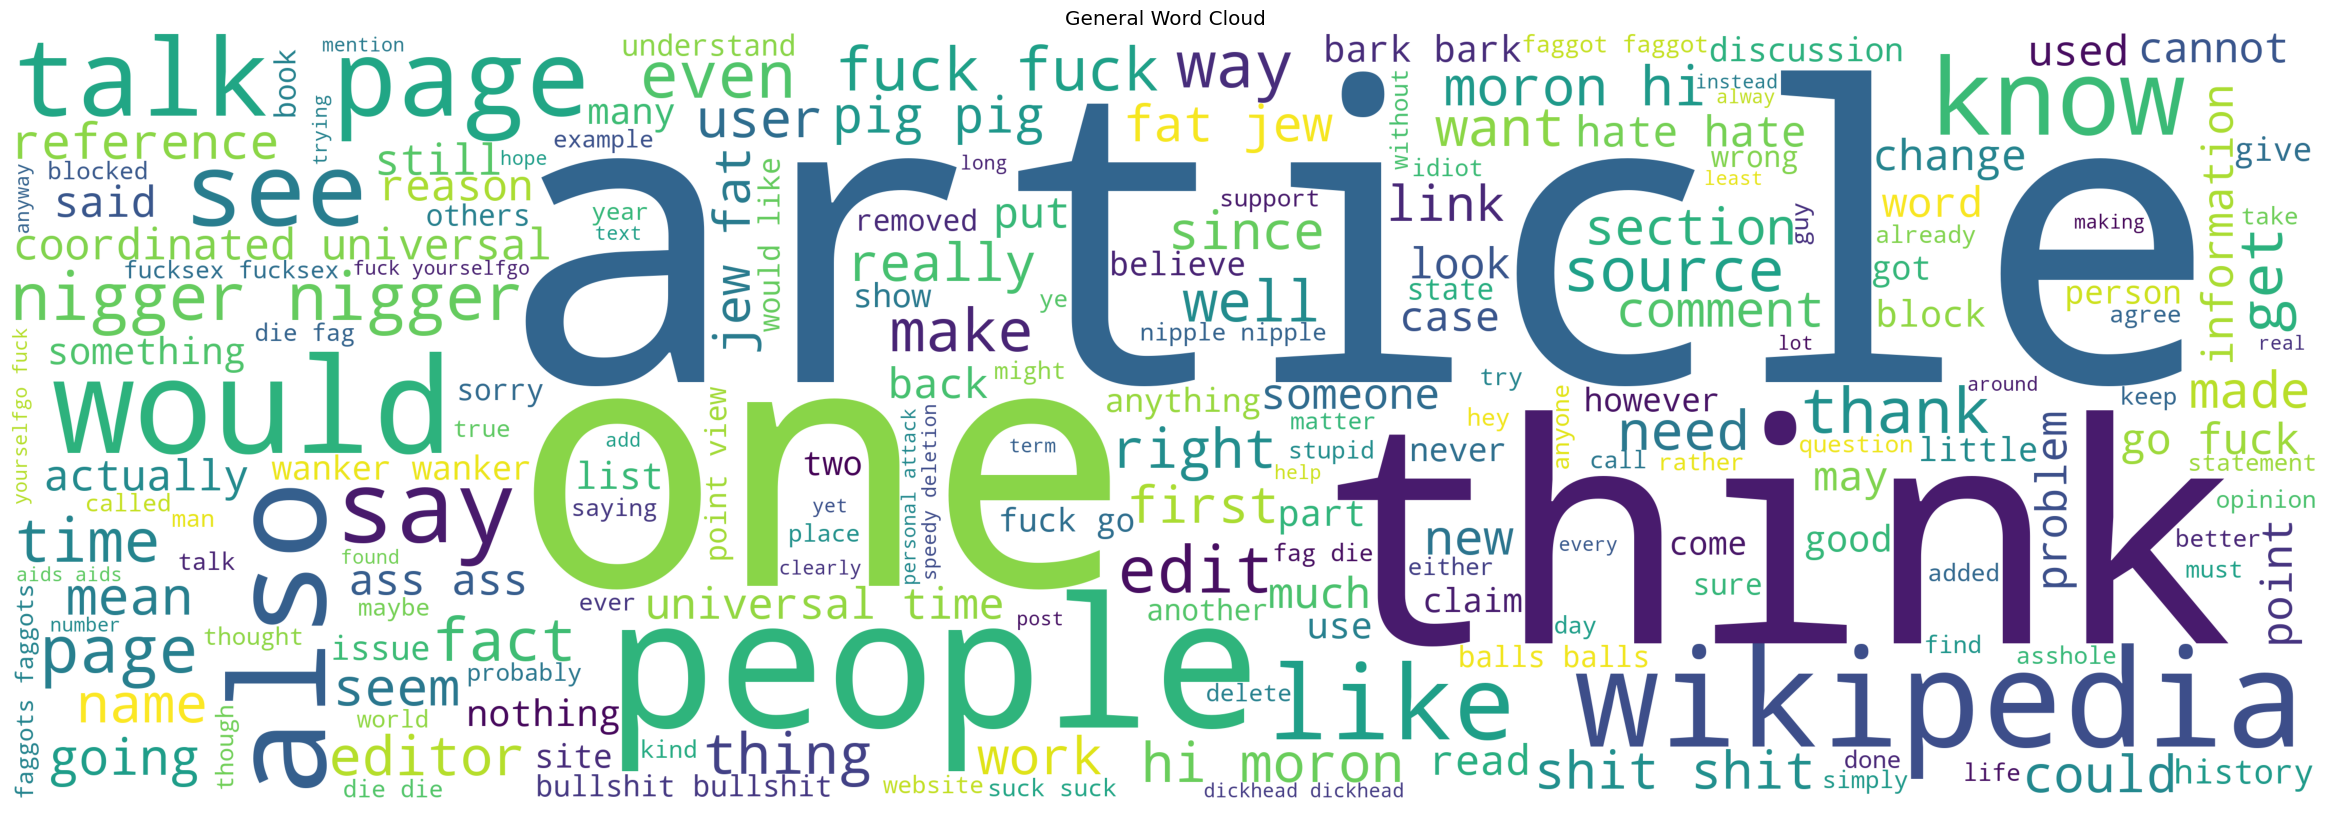

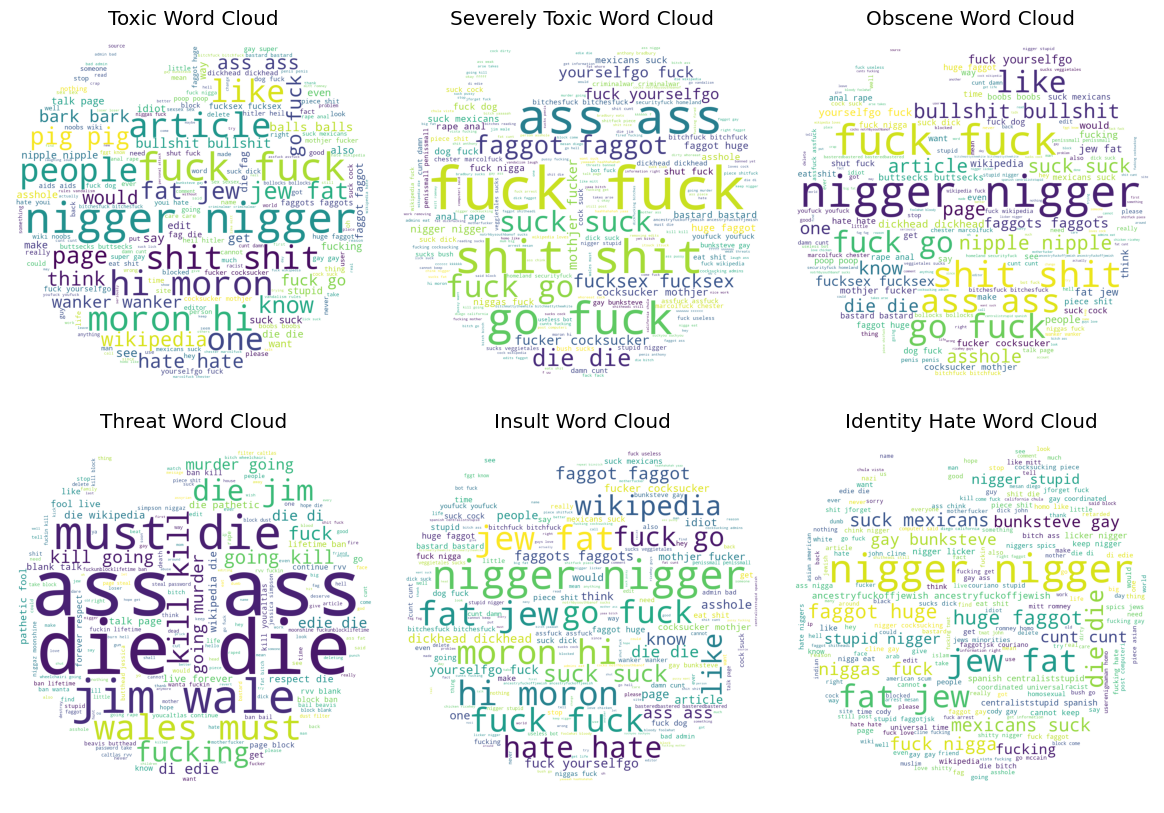

In [10]:
# Visualization
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('ggplot')

mask = np.array(Image.open('./images/wikipedia_mask.jpg'))

def generate_wordcloud(df, clm):
    text = []
    comments = train_data.loc[df[clm] == 1]['text_clean']

    for c in comments:
        text.append(c) 
    words = ' '.join(text)
    return WordCloud(stopwords=stop, background_color='white', mask=mask, height=1500, width=1500).generate(words)

train_toxic = generate_wordcloud(train_data, 'toxic')
train_sev_toxic = generate_wordcloud(train_data, 'severe_toxic')
train_obscene = generate_wordcloud(train_data, 'obscene')
train_threat = generate_wordcloud(train_data, 'threat')
train_insult = generate_wordcloud(train_data, 'insult')
train_id_hate = generate_wordcloud(train_data, 'identity_hate')
train_general = WordCloud(stopwords=stop, background_color='white', height=1500, width=4500).generate(" ".join(train_data['text_clean']))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(45, 10), gridspec_kw = {'wspace':0.01, 'hspace':0.1})
axes.imshow(train_general)
axes.axis('off')
axes.set_title('General Word Cloud')

plt.show()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), gridspec_kw = {'wspace':0.01, 'hspace':0.1})


axes[0][0].imshow(train_toxic)
axes[0][0].axis('off')
axes[0][0].set_title('Toxic Word Cloud')
axes[0][0].set_aspect('equal')

axes[0][1].imshow(train_sev_toxic)
axes[0][1].axis('off')
axes[0][1].set_title('Severely Toxic Word Cloud')
axes[0][1].set_aspect('equal')

axes[0][2].imshow(train_obscene)
axes[0][2].axis('off')
axes[0][2].set_title('Obscene Word Cloud')
axes[0][2].set_aspect('equal')

axes[1][0].imshow(train_threat)
axes[1][0].axis('off')
axes[1][0].set_title('Threat Word Cloud')
axes[1][0].set_aspect('equal')

axes[1][1].imshow(train_insult)
axes[1][1].axis('off')
axes[1][1].set_title('Insult Word Cloud')
axes[1][1].set_aspect('equal')

axes[1][2].imshow(train_id_hate)
axes[1][2].axis('off')
axes[1][2].set_title('Identity Hate Word Cloud')
axes[1][2].set_aspect('equal')


plt.show()

## Salvataggio del dataset pulito
Commentato per non creare problemi nel momento in cui si vuole eseguire il notebook da zero eseguendo tutte le celle.

In [11]:
#header = ['text_lem', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
#train_data.to_csv('data/train_clean.csv', columns = header, index = False)
#test_wlabels.to_csv('data/test_clean.csv', columns = header, index = False)

## Caricamento dati già puliti
Commentato per non creare problemi nel momento in cui si vuole eseguire il notebook da zero eseguendo tutte le celle.  
Nel caso si voglia caricare il dataset già pulito, basta decommentare la cella e far partire l'esecuzione dalla cella sottostante.

In [12]:
#train_data = pd.read_csv('data/train_clean.csv')
#test_data = pd.read_csv('data/test_clean.csv')

## Setup PyTorch e BERT

In presenza di GPU Nvidia si sfrutta l'accellerazione CUDA, altrimenti si utilizza la CPU.

In [13]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
    

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3070


L'ottimizzatore scelto è AdamW, una versione dell'ottimizzatore Adam. Nello specifico Adam (ADaptive Moment Estimation) combina l'idea del momentum con quella del Root Mean Squared Prop (RMSProp) e dunque permette di avere il momentum nelle direzioni dove il gradiente è sempre lo stesso e di smorzarlo quando fluttua in presenza di varianza. In generale ci si sta spostando verso versioni di Adam, come AdamW, in quanto riducono il rischio di overfitting.
Ad AdamW sono stati passati gli iperparametri di BERT e sono stati impostati un *learning rate* pari a *1<sup>-4<sup>* e un *epsilon* pari a *1<sup>-8<sup>*.

Il training è stato fatto su 5 epoche, con una batch size di 16 e *BCE with Logits* come funzione loss. 

>Gli autori di BERT suggeriscono di utilizzare un batch size di 16 o 32, ma in questo caso abbiamo scelto 16 per evitare di esaurire la memoria GPU.

In [14]:
import time
import random
from tqdm import tqdm

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import BertModel

# PreProcessing for bert

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def preprocessing_for_bert(data):
    
    '''
    Add special tokens to the start and end of each sentence.
    Pad & truncate all sentences to a single constant length.
    Explicitly differentiate real tokens from padding tokens with the “attention mask”.

    '''

    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text = sent,
            add_special_tokens = True,
            max_length = 300,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True
        )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    
    # Convert the lists into tensors.
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 6

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.Dropout(0.3),
            nn.Linear(H, D_out),
            )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        # Extract the last hidden state of the token `[CLS]` for classification task
        
        last_hidden_state_cls = outputs[0][:, 0, :]        
        logits = self.classifier(last_hidden_state_cls)

        return logits

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=1e-4,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    best_accuracy = 0
    for epoch_i in range(epochs):

        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()
        step = 0

        # For each batch of training data...
        for batch in tqdm(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()
            b_input_ids = b_input_ids.to(device,dtype=torch.long)
            b_attn_mask = b_attn_mask.to(device,dtype=torch.long)
            b_labels = b_labels.to(device,dtype=torch.float)

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Sigmoid the logits to get probabilities between 0 and 1
            logits = torch.sigmoid(logits)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()
           
        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
        step += 1
        output_folder = "bert_classifier_multilabel"
        filename="./trained_models/"+str(output_folder)

        # create folder if it does not exist

        if not os.path.exists(filename):
            os.makedirs(filename)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            filename="./trained_models/"+str(output_folder)+"/best.pt"
            torch.save(model.state_dict(), filename)

        filename="./trained_models/"+str(output_folder)+"/last.pt"
        torch.save(model.state_dict(), filename)
    
    print("Training complete!")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        logits = torch.sigmoid(logits)
        loss = loss_fn(logits, b_labels.float())
        val_loss.append(loss.item())

        # Get the predictions
        preds = logits
        # Calculate the accuracy rate
        correct_val = 0
        res = 0
        for i in range(6):
            res = 1 if preds[0,i]>0.5 else 0
            if res == b_labels[0,i]:
                correct_val += 1
        val_accuracy.append(correct_val/6)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

# Prepare the data for BERT
train_inputs, train_masks = preprocessing_for_bert(train_data['text_lem'].tolist())
val_inputs, val_masks = preprocessing_for_bert(val_df['text_lem'].tolist())

# Convert other data types to torch.Tensor
train_labels = torch.tensor(train_data[labels].to_numpy())
val_labels = torch.tensor(val_df[labels].to_numpy())

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
# We chose 16 here to avoid memory issues.
batch_size = 16

# Create the DataLoader for our training set
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

# Specify loss function
loss_fn = nn.BCELoss()

# Initialize the BERT classifier
bert_classifier, optimizer, scheduler = initialize_model(epochs=5)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Pulizia della memoria allocata nella GPU
In caso di esecuzione su GPU, questa cella serve per liberare la memoria allocata dalla GPU.
Nel caso l'esecuzione non riesca a liberare la mamoria è consigliato chiudere e riaprire il notebook (e Visual Studio Code nel caso).

In [15]:
import gc
torch.cuda.empty_cache()
gc.collect()

50

## Train

In [16]:
train(bert_classifier, train_dataloader, val_dataloader, epochs=5, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


100%|██████████| 2213/2213 [15:37<00:00,  2.36it/s]


----------------------------------------------------------------------
   1    |    -    |   0.182094   |  0.056498  |   0.98    |  1004.87 
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


100%|██████████| 2213/2213 [15:37<00:00,  2.36it/s]


----------------------------------------------------------------------
   2    |    -    |   0.144736   |  0.060822  |   0.98    |  1004.99 
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


100%|██████████| 2213/2213 [15:31<00:00,  2.37it/s]


----------------------------------------------------------------------
   3    |    -    |   0.124003   |  0.057070  |   0.98    |  996.71  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


100%|██████████| 2213/2213 [15:34<00:00,  2.37it/s]


----------------------------------------------------------------------
   4    |    -    |   0.098667   |  0.062670  |   0.97    |  1001.37 
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


100%|██████████| 2213/2213 [15:17<00:00,  2.41it/s]


----------------------------------------------------------------------
   5    |    -    |   0.075881   |  0.072336  |   0.97    |  981.80  
----------------------------------------------------------------------


Training complete!


## Valutazione e risultati
L'**accuratezza** è una metrica comune per valutare la performance di un modello di classificazione. Si calcola come il numero di predizioni corrette su totale di predizioni fatte. In una classificazione multilabel, l'accuratezza è il rapporto tra il numero di etichette predette correttamente e il numero totale di etichette predette.  

L'**hamming score**, invece, si concentra sul numero di etichette predette correttamente su un numero totale di etichette possibili, quindi risulta una metrica attendibile nelle classificazioni multi-label.
In altre parole, l'hamming score misura il grado di somiglianza tra le etichette predette e quelle effettive, un punteggio più alto indica che le etichette predette sono più simili a quelle effettive.

>Se si vuole caricare il miglior modello già allenato, basta decommentare la cella e far partire l'esecuzione dalla cella sottostante.
>Se non si commenta la cella verrà utilizzato il modello allenato in precedenza più recente.

In [17]:
best_classifier = BertClassifier()
best_classifier.load_state_dict(torch.load('trained_models/bert_classifier_multilabel/best.pt'))
best_classifier.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [18]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []
    labels = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(torch.sigmoid(logits).cpu().detach().numpy().tolist())
   
    return all_logits

In [19]:
# Prepare the data for BERT
test_inputs, test_masks = preprocessing_for_bert(test_data['text_lem'].tolist())

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

# Predict
probs = bert_predict(best_classifier, test_dataloader)

In [20]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    """Compute the average Hamming score (a.k.a. label-based accuracy) for the multi-label case"""
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [21]:
# Transform probabilities to binary values
outputs = []
for p in range(len(probs)):
    for b in range(len(probs[p])):
        aux = []
        for l in range(6):
            aux.append(int(probs[p][b][l] >= 0.5))
        outputs.append(aux)

In [22]:
# Compute accuracy as the average of accuracies for each label
accuracy = []
test_label = test_data[labels].to_numpy()
for p in range(len(outputs)):
    correct_val = 0
    for i in range(6):
        if outputs[p][i] == test_label[p,i]:
            correct_val += 1
    accuracy.append(correct_val/6)
print(f'Accuracy: {np.mean(accuracy)}')

hammingscore = hamming_score(test_label[:1100], outputs)
print("Hamming score: ", hammingscore)

Accuracy: 0.9664351851851852
Hamming score:  0.8666666666666666


# DEMO TEST

In [23]:
def predictions_sentence(sentence):
    sentence = cleaning(sentence)
    sentence, sentence_mask = preprocessing_for_bert([sentence])

    sentence_dataset = TensorDataset(sentence, sentence_mask)
    sentence_sampler = SequentialSampler(sentence_dataset)
    sentence_dataloader = DataLoader(sentence_dataset, sampler=sentence_sampler, batch_size=1)
    prob_sentence = bert_predict(best_classifier,sentence_dataloader)
    outputs = []
    for p in range(len(prob_sentence)):
        for b in range(len(prob_sentence[p])):
            aux = []
            for l in range(6):
                aux.append(int(prob_sentence[p][b][l] >= 0.5))
            outputs.append(aux)
    return outputs

In [26]:
sentence = "I hate you"
prediction = predictions_sentence(sentence)[0]

print(f'toxic: {prediction[0]}, severe toxic: {prediction[1]}, obscene: {prediction[2]}, threat: {prediction[3]}, insult:{prediction[4]}, identity hate: {prediction[5]}')

toxic: 1, severe toxic: 0, obscene: 0, threat: 0, insult:0, identity hate: 0
